##Modelo Predictivo de Prepagos Hipotecarios
# Ingeniería de Características

El objetivo de esta sección es crear nuevas características para mejorar el rendimiento de los modelos, así como utilizar métodos de filtrado para la selección de características relevantes para reducir la complejidad del modelo.

##Carga de información

Se cargan las librerías necesarias y el archivo con los datos.
En este proyecto tenemos dos archivos, el primero contiene la serie histórica de los prepagos realizados desde enero 2019 para los créditos hipotecarios, así como los datos de los clientes de cada crédito. El segundo archivo contiene el saldo insoluto de los créditos, en el mismo formato de serie histórica, contiene también los datos de los clientes por crédito.

Para el proyecto nos enfocaremos en el saldo de los prepagos, pues el saldo insoluto es para observar el prepago en proporción a su saldo.

In [418]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, chi2, f_classif
from sklearn.decomposition import PCA
from sklearn.utils import resample

plt.style.use("seaborn-v0_8")
sns.set_palette("viridis")

In [419]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [420]:
# Cargar archivo Excel
file_path = "/content/drive/MyDrive/MNA/Proyecto Integrador/Ingeniería de características/datos.xlsx"
df_prepago = pd.read_excel(file_path, sheet_name="Prepago")
df_saldo = pd.read_excel(file_path, sheet_name="Saldo Insoluto")

##Construcción



###Paso 1: Valores nulos, atípicos y simplificaciones

En esta sección se aplican las transformaciones discutidas en el avance anterior, estas consisten en:

- Imputar el mínimo Score en clientes con insuficiente historial crediticio.
- Se excluye el crédito con tasa = 0
- Se simplifica el estado civil en dos categorías "SOLTERO" Y "OTROS"
- Se simplifica el estado de la residencia en 5 regiones del país

In [421]:
#imputación de scores

df_prepago["score"].describe()

,score
count,12867.000000
mean,595.622756
std,237.363457
min,-8.000000
25%,652.000000
50%,691.000000
75%,712.000000
max,778.000000


In [422]:
df_prepago[df_prepago["score"] > 0]["score"].min()

461

In [423]:
df_prepago["score"] = df_prepago["score"].apply(lambda x: 461 if x <= 0 else x)
df_prepago["score"].describe()

,score
count,12867.000000
mean,657.570762
std,85.021149
min,461.000000
25%,652.000000
50%,691.000000
75%,712.000000
max,778.000000


In [424]:
#excluir crédito con tasa 0

df_prepago[df_prepago["tasa"] == 0]

,pla_credit,fecha_inicio,edad_cliente,estado_civil,cantidad_otorgada,enganche,clasificacion,score,tasa,plazo_original,...,2024-03-31 00:00:00,2024-04-30 00:00:00,2024-05-31 00:00:00,2024-06-30 00:00:00,2024-07-31 00:00:00,2024-08-31 00:00:00,2024-09-30 00:00:00,2024-10-31 00:00:00,2024-11-30 00:00:00,2024-12-31 00:00:00
8289,200940090040002,NaT,30,SOLTERO,1600000.0,1908000.0,otros,461,0.0,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [425]:
df_prepago = df_prepago[df_prepago["tasa"] != 0]
df_prepago[df_prepago["tasa"] == 0]

,pla_credit,fecha_inicio,edad_cliente,estado_civil,cantidad_otorgada,enganche,clasificacion,score,tasa,plazo_original,...,2024-03-31 00:00:00,2024-04-30 00:00:00,2024-05-31 00:00:00,2024-06-30 00:00:00,2024-07-31 00:00:00,2024-08-31 00:00:00,2024-09-30 00:00:00,2024-10-31 00:00:00,2024-11-30 00:00:00,2024-12-31 00:00:00


Text(0.5, 1.0, 'Frecuencias de Estado Civil')

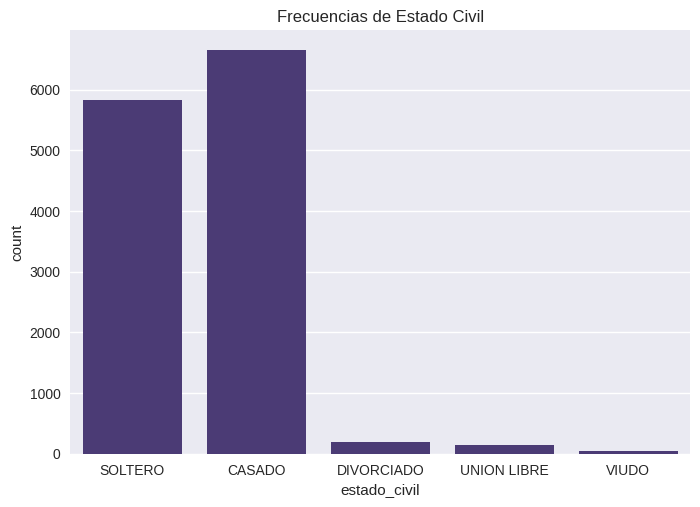

In [426]:
# simplificación del estado civil
sns.countplot(data=df_prepago, x="estado_civil")
plt.title(f"Frecuencias de Estado Civil")

Text(0.5, 1.0, 'Frecuencias de Estado Civil')

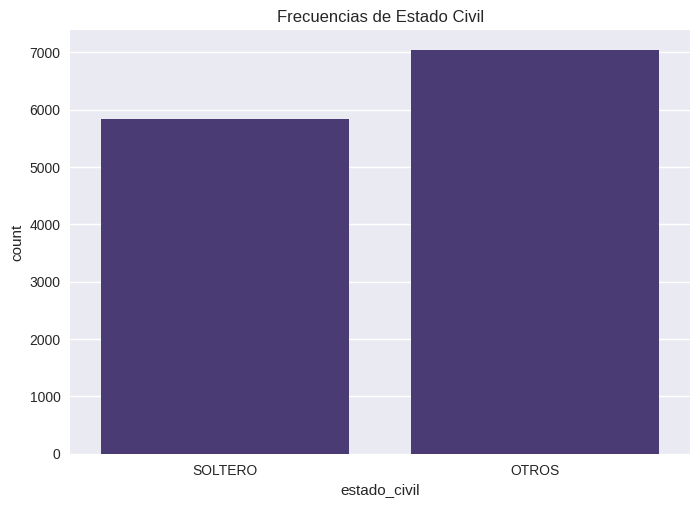

In [427]:
df_prepago["estado_civil"] = np.where(df_prepago["estado_civil"] == "SOLTERO", "SOLTERO", "OTROS")
sns.countplot(data=df_prepago, x="estado_civil")
plt.title(f"Frecuencias de Estado Civil")

In [428]:
# simplificación de estado

print(f"\nFrecuencias de Estados:")
print(df_prepago["estado"].value_counts())


Frecuencias de Estados:
estado
NUEVO LEON                         4223
JALISCO                            1742
QUERETARO                           825
COAHUILA DE ZARAGOZA                750
AGUASCALIENTES                      689
GUANAJUATO                          621
SAN LUIS POTOSI                     544
SONORA                              532
ESTADO DE MEXICO                    456
CIUDAD DE MEXICO                    427
PUEBLA                              328
TAMAULIPAS                          292
BAJA CALIFORNIA                     285
CHIHUAHUA                           271
YUCATAN                             172
ZACATECAS                           142
SINALOA                             139
VERACRUZ DE IGNACIO DE LA LLAVE     120
QUINTANA ROO                        105
MICHOACAN DE OCAMPO                  68
DURANGO                              38
NAYARIT                              33
BAJA CALIFORNIA SUR                  23
MORELOS                              14
HIDALGO 

In [429]:
region_map = {
    #Nuevo Leon
    "NUEVO LEON": "Nuevo Leon",

    #Noroeste
    "BAJA CALIFORNIA": "Noroeste",
    "BAJA CALIFORNIA SUR": "Noroeste",
    "SONORA": "Noroeste",
    "SINALOA": "Noroeste",
    "CHIHUAHUA": "Noroeste",
    "DURANGO": "Noroeste",

    # Noreste
    "COAHUILA": "Noreste",
    "COAHUILA DE ZARAGOZA": "Noreste",
    "TAMAULIPAS": "Noreste",
    "ZACATECAS": "Noreste",
    "SAN LUIS POTOSI": "Noreste",
    "AGUASCALIENTES": "Noreste",

    #Bajio-Occidente
    "JALISCO": "Bajio-Occidente",
    "MICHOACAN": "Bajio-Occidente",
    "MICHOACAN DE OCAMPO": "Bajio-Occidente",
    "COLIMA": "Bajio-Occidente",
    "GUANAJUATO": "Bajio-Occidente",
    "QUERETARO": "Bajio-Occidente",
    "NAYARIT": "Bajio-Occidente",

    #Centro-Sur
    "CIUDAD DE MEXICO": "Centro-Sur",
    "CDMX": "Centro-Sur",
    "ESTADO DE MEXICO": "Centro-Sur",
    "MORELOS": "Centro-Sur",
    "HIDALGO": "Centro-Sur",
    "PUEBLA": "Centro-Sur",
    "TLAXCALA": "Centro-Sur",
    "VERACRUZ": "Centro-Sur",
    "VERACRUZ DE IGNACIO DE LA LLAVE": "Centro-Sur",
    "GUERRERO": "Centro-Sur",
    "OAXACA": "Centro-Sur",
    "CHIAPAS": "Centro-Sur",
    "TABASCO": "Centro-Sur",
    "CAMPECHE": "Centro-Sur",
    "YUCATAN": "Centro-Sur",
    "QUINTANA ROO": "Centro-Sur",
}

# crear la variable
df_prepago["estado"] = df_prepago["estado"].map(region_map)

# manejar estados no mapeados o faltantes
df_prepago["estado"] = df_prepago["estado"].fillna("OTROS")

print(f"\nFrecuencias de Estados:")
print(df_prepago["estado"].value_counts())


Frecuencias de Estados:
estado
Nuevo Leon         4223
Bajio-Occidente    3296
Noreste            2417
Centro-Sur         1642
Noroeste           1288
Name: count, dtype: int64


In [430]:
#para este modelo nos concentraremos en los clientes vigentes a diciembre (son los únicos posibles de prepagar a diciembre y con los que contamos información)

df_prepago = df_prepago[(df_prepago["estatus_dic"] == "VIGENTE") & (df_prepago[pd.Timestamp("2024-11-30")].notna())]

###Paso 2: Creación de variables

Se construirán características nuevas, estas consisten en:

- 'edad_credito': es el porcentaje de vida del crédito a noviembre de 2024 (número de meses transcurridos sobre 'plazo_original_meses').
- 'cantidad_prepago_ratio': es el porcentaje de prepagos observados hasta noviembre (número de prepagos observados sobre número de amortizaciones en la ventana de tiempo).
- 'prepago_total_nov_ratio': porcentaje del monto de prepago observado a noviembre sobre la cantidad otorgada.
- 'prepago_dic': esta es la variable objetivo de la primera fase, 1 si prepagó a diciembre, 0 si no.
- 'enganche_ratio': el enganche como proporción del valor del avalúo (el valor del avalúo será la suma de cantidad otorgada y enganche).
- 'cantidad_prepago_mes': número de prepagos hechos en los meses indicados (ejemplo: 'prepago_enero' es la cantidad de prepagos que se observaron en los meses de enero desde 2019 a 2024).

In [431]:
#creación de edad del crédito

nov = pd.to_datetime("2024-11-30")
df_prepago["fecha_inicio"] = pd.to_datetime(df_prepago["fecha_inicio"])

df_prepago['meses_transcurridos'] = df_prepago['fecha_inicio'].apply(
    lambda x: (nov.year - x.year) * 12 + (nov.month - x.month)
)

df_prepago['edad_credito'] = df_prepago['meses_transcurridos'] / df_prepago['plazo_original_meses']

In [432]:
#ahora creamos la variable que cuente cuantos prepagos hubo en la ventana de tiempo

#primero obtenemos las columnas de fechas de enero 2019 a noviembre 2024
cols = df_prepago.columns
cols_fechas = cols[14:85] #unicamente hasta noviembre
cols_fechas

Index([2019-01-31 00:00:00, 2019-02-28 00:00:00, 2019-03-31 00:00:00,
       2019-04-30 00:00:00, 2019-05-31 00:00:00, 2019-06-30 00:00:00,
       2019-07-31 00:00:00, 2019-08-31 00:00:00, 2019-09-30 00:00:00,
       2019-10-31 00:00:00, 2019-11-30 00:00:00, 2019-12-31 00:00:00,
       2020-01-31 00:00:00, 2020-02-28 00:00:00, 2020-03-31 00:00:00,
       2020-04-30 00:00:00, 2020-05-31 00:00:00, 2020-06-30 00:00:00,
       2020-07-31 00:00:00, 2020-08-31 00:00:00, 2020-09-30 00:00:00,
       2020-10-31 00:00:00, 2020-11-30 00:00:00, 2020-12-31 00:00:00,
       2021-01-31 00:00:00, 2021-02-28 00:00:00, 2021-03-31 00:00:00,
       2021-04-30 00:00:00, 2021-05-31 00:00:00, 2021-06-30 00:00:00,
       2021-07-31 00:00:00, 2021-08-31 00:00:00, 2021-09-30 00:00:00,
       2021-10-31 00:00:00, 2021-11-30 00:00:00, 2021-12-31 00:00:00,
       2022-01-31 00:00:00, 2022-02-28 00:00:00, 2022-03-31 00:00:00,
       2022-04-30 00:00:00, 2022-05-31 00:00:00, 2022-06-30 00:00:00,
       2022-07-31 00

In [433]:
#calcula cuantos prepagos fueron mayores a 0
df_prepago['conteo_prepagos'] = df_prepago[cols_fechas].gt(0).sum(axis=1)

#calcula cuantas amortizaciones tenemos en la ventana de tiempo
df_prepago["amortizaciones"] = df_prepago[cols_fechas].notna().sum(axis=1)

#calculamos cantidad_prepago_ratio como la división

df_prepago["cantidad_prepago_ratio"] = df_prepago["conteo_prepagos"] / df_prepago["amortizaciones"]

#ahora calculamos el prepago total a noviembre

df_prepago["prepago_total_nov"] = df_prepago[cols_fechas].sum(axis=1)

#calculamos el prepago a nov sobre la cantidad otorgada

df_prepago["prepago_total_ratio"] = df_prepago["prepago_total_nov"] / df_prepago["cantidad_otorgada"]

#calculamos la variable objetivo, prepago_dic, con 1 si hubo prepago en dic y 0 si no

df_prepago["prepago_dic"] = np.where(df_prepago[cols[85]] > 0, 1, 0)

#calculamos el engache_ratio como el engache sobre el valor del avalúo

df_prepago["enganche_ratio"] = df_prepago["enganche"] / (df_prepago["cantidad_otorgada"] + df_prepago["enganche"])

In [434]:
#fechas con los meses
ene = [col for col in cols_fechas if col.month == 1]
feb = [col for col in cols_fechas if col.month == 2]
mar = [col for col in cols_fechas if col.month == 3]
abr = [col for col in cols_fechas if col.month == 4]
may = [col for col in cols_fechas if col.month == 5]
jun = [col for col in cols_fechas if col.month == 6]
jul = [col for col in cols_fechas if col.month == 7]
ago = [col for col in cols_fechas if col.month == 8]
sep = [col for col in cols_fechas if col.month == 9]
oct = [col for col in cols_fechas if col.month == 10]
nov = [col for col in cols_fechas if col.month == 11]
dic = [col for col in cols_fechas if col.month == 12]

df_prepago["cantidad_prepago_1"] = df_prepago[ene].gt(0).sum(axis=1)
df_prepago["cantidad_prepago_2"] = df_prepago[feb].gt(0).sum(axis=1)
df_prepago["cantidad_prepago_3"] = df_prepago[mar].gt(0).sum(axis=1)
df_prepago["cantidad_prepago_4"] = df_prepago[abr].gt(0).sum(axis=1)
df_prepago["cantidad_prepago_5"] = df_prepago[may].gt(0).sum(axis=1)
df_prepago["cantidad_prepago_6"] = df_prepago[jun].gt(0).sum(axis=1)
df_prepago["cantidad_prepago_7"] = df_prepago[jul].gt(0).sum(axis=1)
df_prepago["cantidad_prepago_8"] = df_prepago[ago].gt(0).sum(axis=1)
df_prepago["cantidad_prepago_9"] = df_prepago[sep].gt(0).sum(axis=1)
df_prepago["cantidad_prepago_10"] = df_prepago[oct].gt(0).sum(axis=1)
df_prepago["cantidad_prepago_11"] = df_prepago[nov].gt(0).sum(axis=1)
df_prepago["cantidad_prepago_12"] = df_prepago[dic].gt(0).sum(axis=1)

df_prepago.head()

,pla_credit,fecha_inicio,edad_cliente,estado_civil,cantidad_otorgada,enganche,clasificacion,score,tasa,plazo_original,...,cantidad_prepago_3,cantidad_prepago_4,cantidad_prepago_5,cantidad_prepago_6,cantidad_prepago_7,cantidad_prepago_8,cantidad_prepago_9,cantidad_prepago_10,cantidad_prepago_11,cantidad_prepago_12
0,1000190116002,2020-10-05,41,SOLTERO,10000000.0,23131000.0,otros,705,8.55,19,...,0,0,0,0,0,0,0,0,0,0
1,1008720301002,2022-02-22,56,OTROS,3240000.0,760000.0,Adquisicion de vivienda,697,9.40,15,...,0,0,0,0,0,1,0,1,0,0
2,1017890120001,2020-09-11,53,OTROS,1535100.0,270900.0,Adquisicion de vivienda,704,10.25,20,...,0,0,0,1,0,0,0,0,0,1
6,1030890139001,2019-09-27,46,SOLTERO,1420000.0,2932000.0,Adquisicion de vivienda,720,10.75,19,...,0,0,0,0,1,0,0,0,0,0
7,1043410110001,2018-12-18,44,OTROS,15000000.0,33057000.0,Adquisicion de vivienda,720,9.40,14,...,1,0,1,0,0,0,1,0,1,0


In [435]:
#nos quedamos con el data frame limpio, con las variables de interés

num_vars = ["edad_cliente", "score","tasa", "plazo_original_meses", "edad_credito", "cantidad_prepago_ratio", "prepago_total_ratio", "enganche_ratio", "cantidad_prepago_1", "cantidad_prepago_2", "cantidad_prepago_3", "cantidad_prepago_4", "cantidad_prepago_5", "cantidad_prepago_6", "cantidad_prepago_7", "cantidad_prepago_8", "cantidad_prepago_9", "cantidad_prepago_10", "cantidad_prepago_11", "cantidad_prepago_12"]
cat_vars = ["estado_civil","clasificacion", "estado", "prepago_dic"]

df = df_prepago[num_vars + cat_vars]
df.head()

,edad_cliente,score,tasa,plazo_original_meses,edad_credito,cantidad_prepago_ratio,prepago_total_ratio,enganche_ratio,cantidad_prepago_1,cantidad_prepago_2,...,cantidad_prepago_7,cantidad_prepago_8,cantidad_prepago_9,cantidad_prepago_10,cantidad_prepago_11,cantidad_prepago_12,estado_civil,clasificacion,estado,prepago_dic
0,41,705,8.55,228,0.214912,0.000000,0.000000,0.698168,0,0,...,0,0,0,0,0,0,SOLTERO,otros,Nuevo Leon,0
1,56,697,9.40,180,0.183333,0.058824,0.016907,0.190000,0,0,...,0,1,0,1,0,0,OTROS,Adquisicion de vivienda,Nuevo Leon,0
2,53,704,10.25,240,0.208333,0.058824,0.026057,0.150000,1,0,...,0,0,0,0,0,1,OTROS,Adquisicion de vivienda,Nuevo Leon,0
6,46,720,10.75,228,0.271930,0.015873,0.274648,0.673713,0,0,...,1,0,0,0,0,0,SOLTERO,Adquisicion de vivienda,Nuevo Leon,0
7,44,720,9.40,168,0.422619,0.056338,0.333333,0.687871,0,0,...,0,0,1,0,1,0,OTROS,Adquisicion de vivienda,Nuevo Leon,0


In [436]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7381 entries, 0 to 12866
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   edad_cliente            7381 non-null   int64  
 1   score                   7381 non-null   int64  
 2   tasa                    7381 non-null   float64
 3   plazo_original_meses    7381 non-null   int64  
 4   edad_credito            7381 non-null   float64
 5   cantidad_prepago_ratio  7381 non-null   float64
 6   prepago_total_ratio     7381 non-null   float64
 7   enganche_ratio          7381 non-null   float64
 8   cantidad_prepago_1      7381 non-null   int64  
 9   cantidad_prepago_2      7381 non-null   int64  
 10  cantidad_prepago_3      7381 non-null   int64  
 11  cantidad_prepago_4      7381 non-null   int64  
 12  cantidad_prepago_5      7381 non-null   int64  
 13  cantidad_prepago_6      7381 non-null   int64  
 14  cantidad_prepago_7      7381 non-null   int6

###Paso 3: Codificación de variables categóricas

Por último, se codifican las variables categóricas utilizando una variable binaria para estado_civil ("SOLTERO" = 0 y "OTROS" = 1) y One-Hot Encoding para clasificación (3) y estado (5), esto debido a que:

- las variables no tienen orden natural, es decir, la clasificación corresponde al tipo de producto respecto a "Vivienda", "Terrenos" y "Otros", y uno no se puede clasificar como mayor o menor a otro en algún tipo de orden específico. Por otro lado, la región de la residencia, aunque pudiera estar más cercano a alguna otra región en específico, pudieran no compartir más características fuera de la geografía, es decir, cada región tiene sus propias características cualitativas en términos de perspectivas económicas, climatológicas, o culturales, que pudieran reflejarse en el comportamiento de prepago.

- con One-Hot Encoding cada columna binaria obtendrá su propio peso en el modelo, que nos permitirá captar las diferencias de cada categoría, haciendo más clara la interpretabilidad.

In [437]:
#transformamos en variable binaria el estado_civil

df_model = df
df_model['estado_civil'] = (df['estado_civil'] == 'OTROS').astype(int)

#One-Hot para clasificacion y estado

dummies_clasificacion = pd.get_dummies(df['clasificacion'], prefix='clasificacion', dummy_na=False).astype(int)
dummies_estado = pd.get_dummies(df['estado'],      prefix='region',  dummy_na=False).astype(int)

df_model = pd.concat([df_model, dummies_clasificacion, dummies_estado], axis=1)

/tmp/ipython-input-2069689136.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['estado_civil'] = (df['estado_civil'] == 'OTROS').astype(int)


In [438]:
df_model.head()

,edad_cliente,score,tasa,plazo_original_meses,edad_credito,cantidad_prepago_ratio,prepago_total_ratio,enganche_ratio,cantidad_prepago_1,cantidad_prepago_2,...,estado,prepago_dic,clasificacion_Adquisicion de terrenos,clasificacion_Adquisicion de vivienda,clasificacion_otros,region_Bajio-Occidente,region_Centro-Sur,region_Noreste,region_Noroeste,region_Nuevo Leon
0,41,705,8.55,228,0.214912,0.000000,0.000000,0.698168,0,0,...,Nuevo Leon,0,0,0,1,0,0,0,0,1
1,56,697,9.40,180,0.183333,0.058824,0.016907,0.190000,0,0,...,Nuevo Leon,0,0,1,0,0,0,0,0,1
2,53,704,10.25,240,0.208333,0.058824,0.026057,0.150000,1,0,...,Nuevo Leon,0,0,1,0,0,0,0,0,1
6,46,720,10.75,228,0.271930,0.015873,0.274648,0.673713,0,0,...,Nuevo Leon,0,0,1,0,0,0,0,0,1
7,44,720,9.40,168,0.422619,0.056338,0.333333,0.687871,0,0,...,Nuevo Leon,0,0,1,0,0,0,0,0,1


##Normalización

En esta sección se escalarán las variables necesarias para garantizar que todas tengan un impacto comparable en el modelo.

Para esto, primero se evaluará qué variables necesitan una transformación, dependiendo de qué tan sesgada esté su distribución.

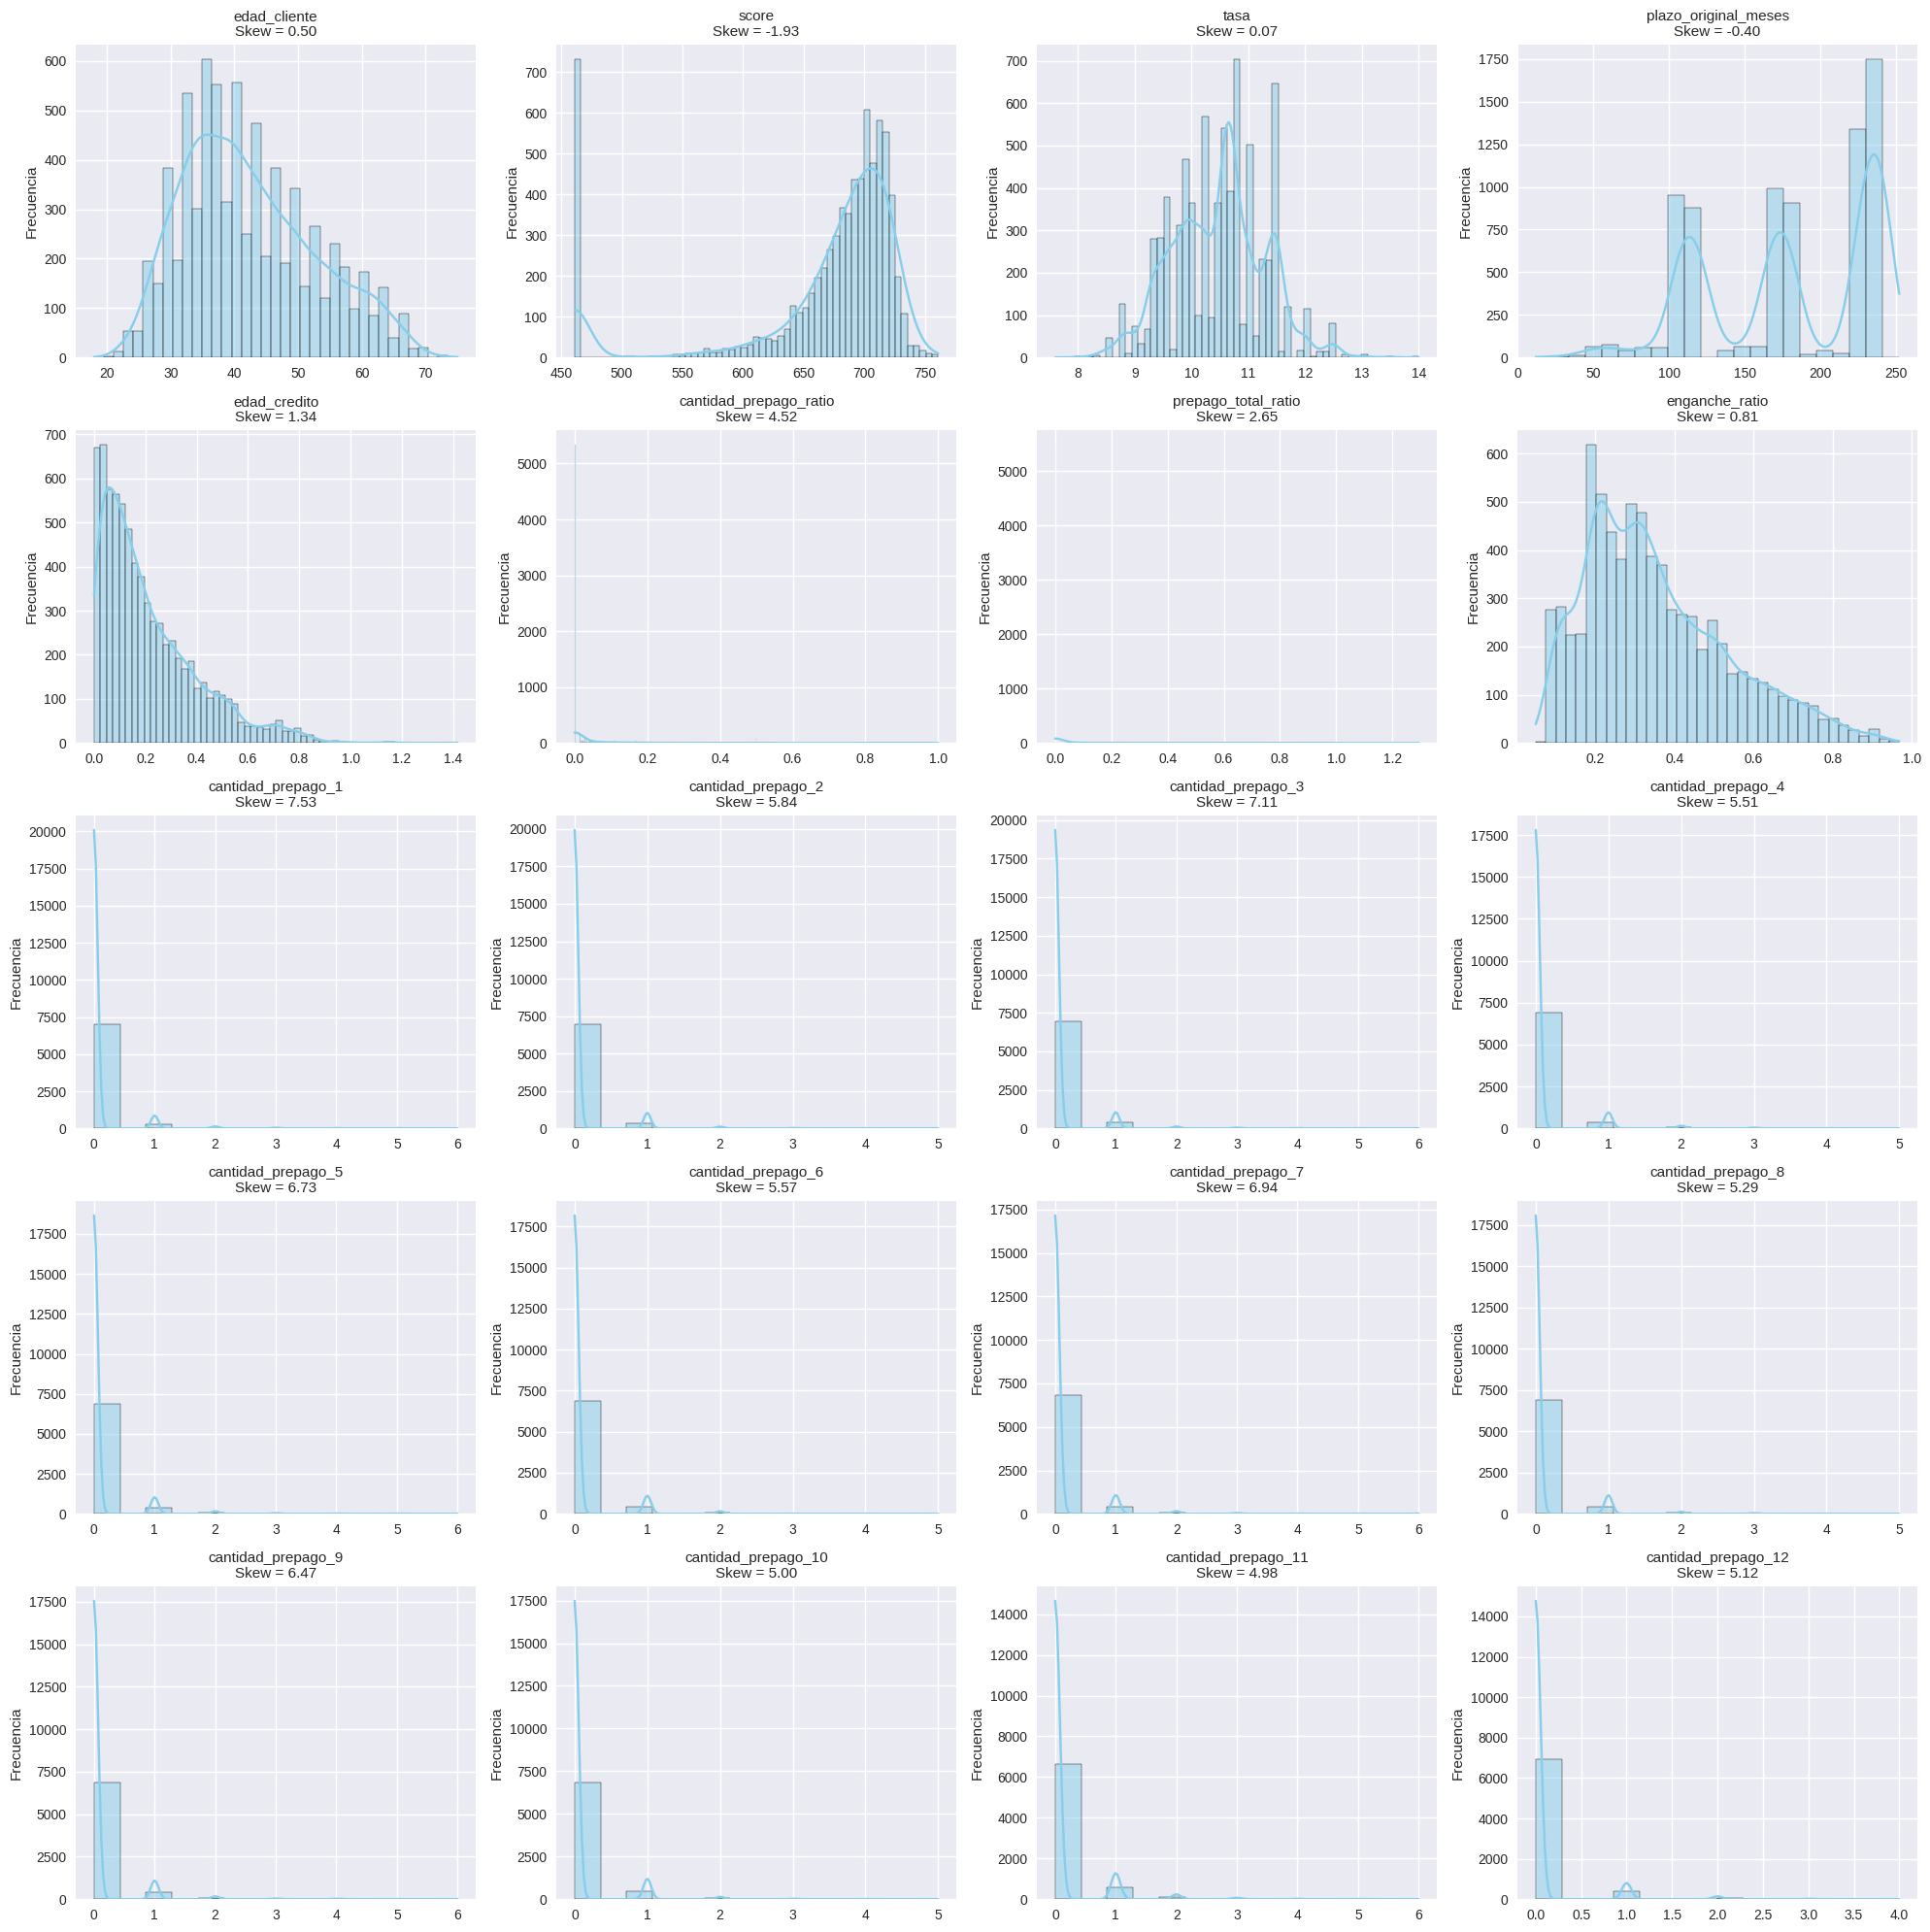

In [439]:
cols = [
    "edad_cliente", "score", "tasa", "plazo_original_meses", "edad_credito",
    "cantidad_prepago_ratio", "prepago_total_ratio", "enganche_ratio"
] + [f"cantidad_prepago_{i}" for i in range(1, 13)]

filas = 5
plt.figure(figsize=(20, 20))

for i, col in enumerate(cols):
    plt.subplot(filas, 4, i + 1)
    sns.histplot(df_model[col], kde=True, color="skyblue")
    skew_val = df_model[col].skew()
    plt.title(f"{col}\nSkew = {skew_val:.2f}", fontsize=11)
    plt.xlabel("")
    plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()

In [440]:
#calculamos la asimetría
skewness = df_model[cols].skew().sort_values(ascending=False)
print(skewness)

cantidad_prepago_1        7.532308
cantidad_prepago_3        7.105455
cantidad_prepago_7        6.936038
cantidad_prepago_5        6.733843
cantidad_prepago_9        6.474376
cantidad_prepago_2        5.841530
cantidad_prepago_6        5.565683
cantidad_prepago_4        5.508419
cantidad_prepago_8        5.289384
cantidad_prepago_12       5.121707
cantidad_prepago_10       4.997729
cantidad_prepago_11       4.980675
cantidad_prepago_ratio    4.518891
prepago_total_ratio       2.653200
edad_credito              1.341899
enganche_ratio            0.806483
edad_cliente              0.501440
tasa                      0.068042
plazo_original_meses     -0.404754
score                    -1.926454
dtype: float64


- Sin transformación: la 'tasa', 'edad_cliente' y 'plazo_original_meses' no serán transformadas ya que se observan simétricas, con bajo sesgo.

- Yeo-Johnson: se aplicará a 'edad_credito', 'enganche_ratio' y 'score'. Esto es porque estas variables están muy sesgadas (a la derecha para las primeras dos y a la izquierda para el score). Se utiliza Yeo-Johnson porque esta transformación corregirá este sesgo pero también considerando que hay varios valores cercanos a cero, para el caso de 'edad_credito' y 'enganche_ratio'.

- Log(1+x): se aplicará a 'cantidad_prepago_ratio', 'prepago_total_ratio' y las variables de 'cantidad_prepago' para cada mes. Estas distribuciones tienen muchos valores en 0, y una cola muy larga (valores altos). Esta transformación reducirá las colas del lado derecho, pues en los tres casos existe un sesgo muy importando, pero también con muchos valores en 0. También ayudará a estabilizar la varianza.

In [441]:
df_t = df_model

# log(1+x)
cols_log = ['cantidad_prepago_ratio', 'prepago_total_ratio'] + [f'cantidad_prepago_{i}' for i in range(1,13)]
df_t[cols_log] = df_t[cols_log].apply(lambda x: np.log1p(x))

# Yeo–Johnson
cols_yeo = ['edad_credito', 'enganche_ratio', 'score']
pt = PowerTransformer(method='yeo-johnson')
df_t[cols_yeo] = pt.fit_transform(df_t[cols_yeo])

# sin transformación
cols_no = ['edad_cliente', 'tasa', 'plazo_original_meses']

Por último, para homogeneizar la escala, aplicamos un escalamiento Z-score. De esta forma, se centrarán las variables en 0, con varianza escalada en 1, y ninguna variable dominará por tener valores más grandes.

In [442]:
# Z-score
scaler = StandardScaler()
df_t[cols_log + cols_yeo + cols_no] = scaler.fit_transform(df_t[cols_log + cols_yeo + cols_no])

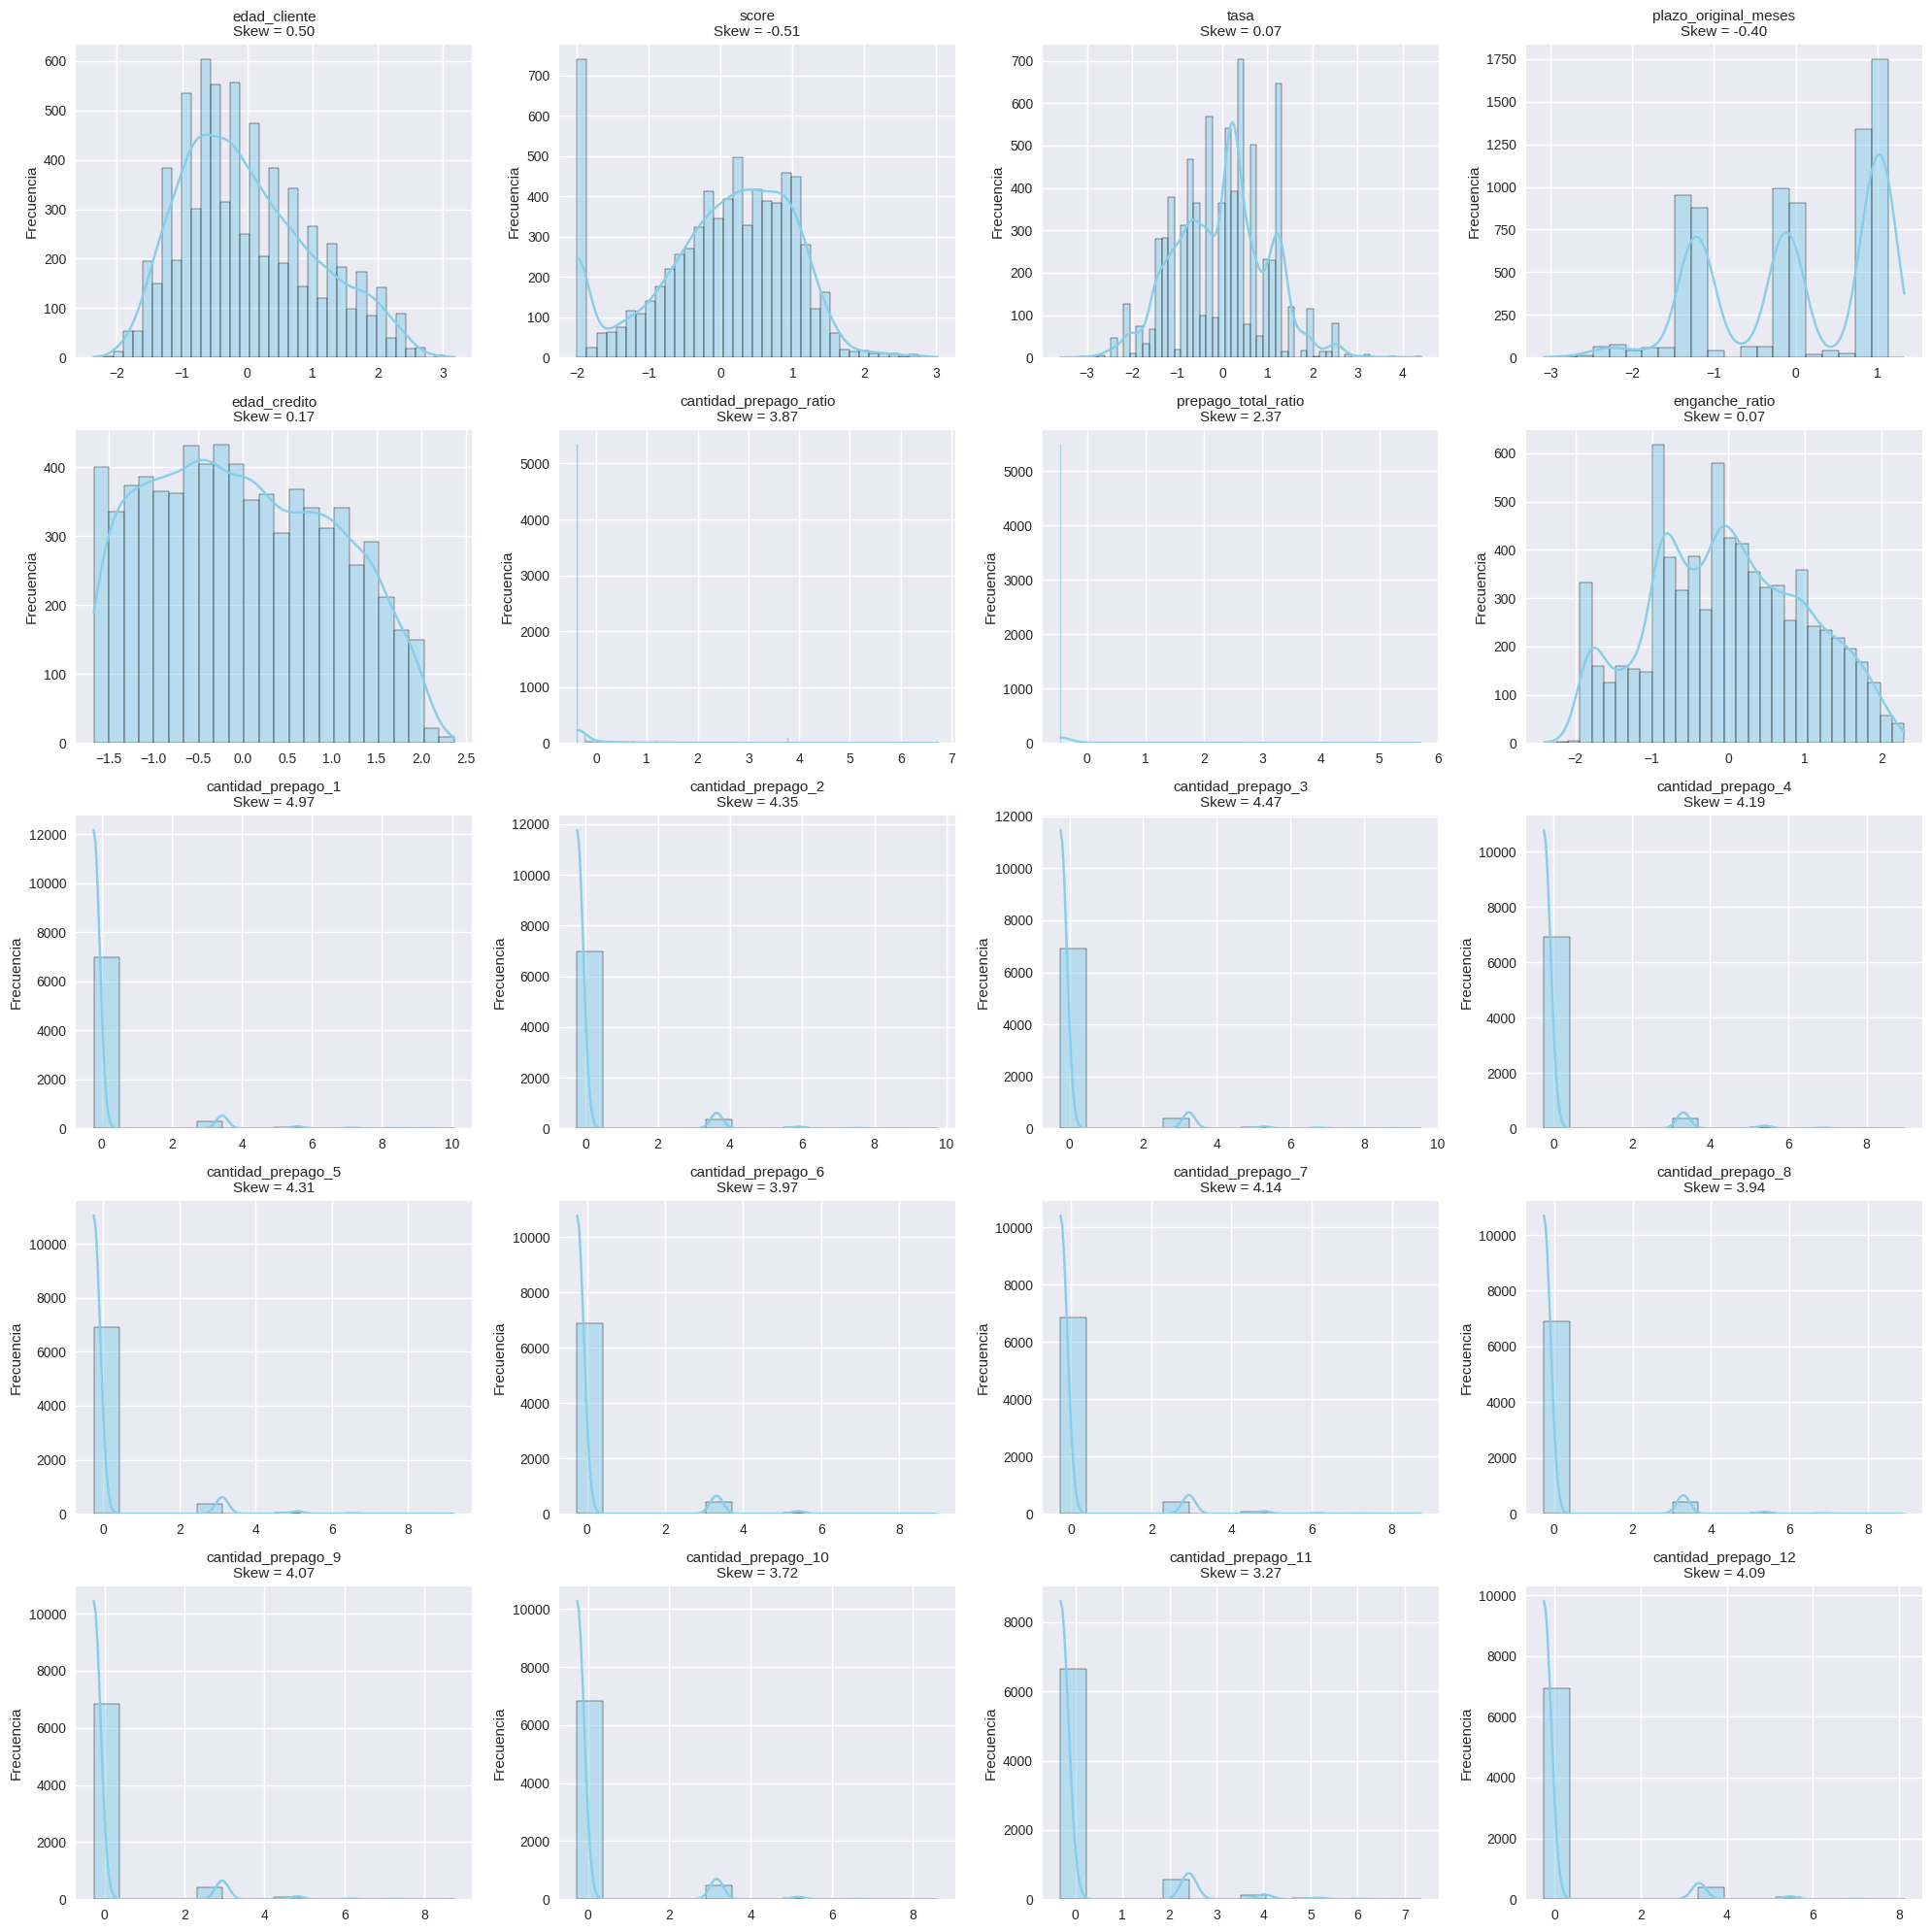

In [443]:
#observamos el resultado final

filas = 5
plt.figure(figsize=(20, 20))

for i, col in enumerate(cols):
    plt.subplot(filas, 4, i + 1)
    sns.histplot(df_t[col], kde=True, color="skyblue")
    skew_val = df_t[col].skew()
    plt.title(f"{col}\nSkew = {skew_val:.2f}", fontsize=11)
    plt.xlabel("")
    plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()

##Selección de variables

En esta sección se aplicarán distintos análisis para reducir la dimensionalidad y por tanto la complejidad del modelo.

In [444]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7381 entries, 0 to 12866
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   edad_cliente                           7381 non-null   float64
 1   score                                  7381 non-null   float64
 2   tasa                                   7381 non-null   float64
 3   plazo_original_meses                   7381 non-null   float64
 4   edad_credito                           7381 non-null   float64
 5   cantidad_prepago_ratio                 7381 non-null   float64
 6   prepago_total_ratio                    7381 non-null   float64
 7   enganche_ratio                         7381 non-null   float64
 8   cantidad_prepago_1                     7381 non-null   float64
 9   cantidad_prepago_2                     7381 non-null   float64
 10  cantidad_prepago_3                     7381 non-null   float64
 11  cantidad

In [445]:
num_vars = ["edad_cliente", "score","tasa", "plazo_original_meses", "edad_credito", "cantidad_prepago_ratio", "prepago_total_ratio", "enganche_ratio", "cantidad_prepago_1", "cantidad_prepago_2", "cantidad_prepago_3", "cantidad_prepago_4", "cantidad_prepago_5", "cantidad_prepago_6", "cantidad_prepago_7", "cantidad_prepago_8", "cantidad_prepago_9", "cantidad_prepago_10", "cantidad_prepago_11", "cantidad_prepago_12"]
cat_vars = ["estado_civil"]
dummys_clasificacion = ["clasificacion_Adquisicion de terrenos", "clasificacion_Adquisicion de vivienda", "clasificacion_otros"]
dummys_estado = ["region_Bajio-Occidente", "region_Centro-Sur", "region_Noroeste", "region_Noreste", "region_Nuevo Leon"]
var_objetivo = ["prepago_dic"]

dummys_clasificacion_drop = ["clasificacion_Adquisicion de terrenos", "clasificacion_Adquisicion de vivienda"]
dummys_estado_drop = ["region_Bajio-Occidente", "region_Centro-Sur", "region_Noroeste", "region_Noreste"]

In [446]:
y = df_t[var_objetivo]
X = df_t[num_vars + cat_vars + dummys_clasificacion + dummys_estado]

Definimos también un "X" y "y" muestreado para una clase balanceada de "prepago_dic" y validar resultados con y sin muestreo.

In [447]:
df_t_0 = df_t[df_t["prepago_dic"] == 0]
df_t_1 = df_t[df_t["prepago_dic"] == 1]

df_t_0_sample = resample(df_t_0, replace = False, n_samples = len(df_t_1), random_state = 0)

df_t_sample = pd.concat([df_t_0_sample, df_t_1])

y_sample = df_t_sample[var_objetivo]
X_sample = df_t_sample[num_vars + cat_vars + dummys_clasificacion + dummys_estado]

###Paso 1: Análisis de umbral de varianza

Aquí se identificaran las variables que aportan poca señal y pueden meter ruido en el modelo. Se identificarán a las variables con varianza menor al 0.05.

In [448]:
vt = VarianceThreshold(threshold=0.05)
vt.fit(X)
mask_keep = vt.get_support()
cols_keep = X.columns[mask_keep]
cols_drop_vt = X.columns[~mask_keep].tolist()
vt_table = pd.DataFrame({"feature_drop_vt": cols_drop_vt})

vt_table

,feature_drop_vt


El resultado anterior significa que ninguna variable permanece demasiado constante, es decir, todas aportan variabilidad, por lo que no se debe excluir ninguna por este criterio.

###Paso 2: Correlación

Aquí se calcula la correlación de las variables contra la variable objetivo, para identificar a las importantes. Aunque cabe mencionar que esto no detecta correlaciones no lineales ni interacciones entre distintas variables.

In [449]:
#datos originales

y = y.squeeze()
y_num = pd.to_numeric(y, errors="coerce")
correlacion = X.corrwith(y_num, method='pearson').to_frame("correlacion_con_variable_objetivo")
correlacion["correlacion_con_variable_objetivo"] = correlacion["correlacion_con_variable_objetivo"].round(2)
correlacion.sort_values(by="correlacion_con_variable_objetivo", ascending=False)

,correlacion_con_variable_objetivo
cantidad_prepago_ratio,0.38
cantidad_prepago_10,0.25
cantidad_prepago_11,0.25
prepago_total_ratio,0.23
cantidad_prepago_8,0.23
cantidad_prepago_6,0.22
cantidad_prepago_9,0.21
cantidad_prepago_7,0.21
cantidad_prepago_12,0.18
cantidad_prepago_4,0.18


In [450]:
#datos balanceados

y_sample = y_sample.squeeze()
y_sample_num = pd.to_numeric(y_sample, errors="coerce")
correlacion = X_sample.corrwith(y_sample_num , method='pearson').to_frame("correlacion_con_variable_objetivo")

correlacion["correlacion_con_variable_objetivo"] = correlacion["correlacion_con_variable_objetivo"].round(2)
correlacion.sort_values(by="correlacion_con_variable_objetivo", ascending=False)

,correlacion_con_variable_objetivo
cantidad_prepago_ratio,0.45
prepago_total_ratio,0.41
cantidad_prepago_11,0.39
cantidad_prepago_9,0.31
cantidad_prepago_10,0.31
cantidad_prepago_8,0.31
cantidad_prepago_7,0.30
cantidad_prepago_6,0.29
cantidad_prepago_5,0.28
cantidad_prepago_12,0.25


Los resultados anteriores indican que las variables más directamente relacionadas con nuestra variable objetivo son el prepago observado, tanto en cantidad como en monto (en porcentaje de la cantidad otorgada).

###Paso 3: Análisis de la Chi-cuadrada

Para las variables categóricas, en formato dummy, se calcula el estadístico de la chi-cuadrada para saber cuales tienen una relación significativa con la variable objetivo.

In [451]:
#datos originales

X_cat = df_t[cat_vars + dummys_clasificacion + dummys_estado]
chi2_stats, chi2_p = chi2(X_cat, y)
chi2_table = pd.DataFrame({
    "variable": X_cat.columns,
    "F": chi2_stats,
    "p_value": chi2_p
}).sort_values(by="p_value", ascending=True).reset_index(drop=True)

chi2_table

,variable,F,p_value
0,region_Noreste,8.296665,0.003972
1,region_Nuevo Leon,7.658272,0.005651
2,clasificacion_Adquisicion de vivienda,6.482019,0.010897
3,clasificacion_Adquisicion de terrenos,6.087089,0.013617
4,clasificacion_otros,4.806981,0.028345
5,region_Bajio-Occidente,1.696665,0.192725
6,estado_civil,1.035791,0.308802
7,region_Centro-Sur,0.165728,0.683936
8,region_Noroeste,0.140948,0.707341


In [452]:
#datos balanceados

X_sample_cat = df_t_sample[cat_vars + dummys_clasificacion + dummys_estado]
chi2_stats, chi2_p = chi2(X_sample_cat, y_sample)
chi2_table = pd.DataFrame({
    "variable": X_sample_cat.columns,
    "F": chi2_stats,
    "p_value": chi2_p
}).sort_values(by="p_value", ascending=True).reset_index(drop=True)

chi2_table

,variable,F,p_value
0,region_Nuevo Leon,5.326848,0.020999
1,clasificacion_Adquisicion de vivienda,5.069307,0.024353
2,region_Noreste,3.755556,0.052632
3,clasificacion_Adquisicion de terrenos,3.204506,0.073436
4,clasificacion_otros,1.920635,0.165787
5,estado_civil,1.115207,0.290953
6,region_Bajio-Occidente,0.373272,0.541226
7,region_Noroeste,0.045455,0.831170
8,region_Centro-Sur,0.000000,1.000000


Los resultados anteriores indican que la pertenencia a la región  Nuevo León es significativa respecto a nuestra variable objetivo. También la clasificación de productos de vivienda es significativa respecto a la variable objetivo.

La región Noreste aunque es significativa en los datos completos, el p-value es ligeramente superior a 0.05 con la muestra de los datos ya balanceados.

###Paso 4: Análisis ANOVA

Para las variables numéricas se realiza un análisis ANOVA para determinar cuánto puede explicar una variable explicativa a nuestra variable objetivo. Para cada variable compara la media entre los dos grupos (con prepago a diciembre y sin prepago a diciembre), si la diferencia es significativa el p-value será bajo.

In [453]:
#datos originales

F, pvals = f_classif(X, y)
anova_table = pd.DataFrame({
    "feature": X.columns,
    "F_stat": F,
    "p_value": pvals
}).sort_values(by="p_value", ascending=True).reset_index(drop=True)

anova_table["p_value"] = anova_table["p_value"].round(2)

anova_table

,feature,F_stat,p_value
0,cantidad_prepago_ratio,1254.941340,0.00
1,cantidad_prepago_10,492.092482,0.00
2,cantidad_prepago_11,479.818884,0.00
3,prepago_total_ratio,409.846187,0.00
4,cantidad_prepago_8,394.833272,0.00
5,cantidad_prepago_6,365.357451,0.00
6,cantidad_prepago_9,347.573079,0.00
7,cantidad_prepago_7,332.176482,0.00
8,cantidad_prepago_12,259.371749,0.00
9,cantidad_prepago_4,240.270163,0.00


In [454]:
#datos balanceados

F, pvals = f_classif(X_sample, y_sample)
anova_table = pd.DataFrame({
    "feature": X_sample.columns,
    "F_stat": F,
    "p_value": pvals
}).sort_values(by="p_value", ascending=True).reset_index(drop=True)

anova_table["p_value"] = anova_table["p_value"].round(2)

anova_table

,feature,F_stat,p_value
0,cantidad_prepago_ratio,215.346292,0.00
1,prepago_total_ratio,170.833974,0.00
2,cantidad_prepago_11,146.325802,0.00
3,cantidad_prepago_10,90.738036,0.00
4,cantidad_prepago_9,89.227103,0.00
5,cantidad_prepago_8,87.794574,0.00
6,cantidad_prepago_7,84.461728,0.00
7,cantidad_prepago_6,74.537461,0.00
8,cantidad_prepago_5,73.334443,0.00
9,cantidad_prepago_12,55.425037,0.00


El análisis de ANOVA indica que la media entre los grupos de sin prepago y con prepago a diciembre es significativamente distinta en las variables de prepagos (en cantidades y monto), en score, clasificación de terrenos y vivienda, región nuevo león y noreste, y la edad del crédito.

###Paso 5: Análisis de principales componentes PCA

Útil para determinar el número de variables que logran explicar cierto porcentaje de la varianza total de los datos y evaluar si reducir dimensionalidad.

In [455]:
#datos originales

pca = PCA(n_components=29, random_state=0)
pca.fit(X)

pca_explained = pd.DataFrame({
    "componente": [f"PC{i+1}" for i in range(29)],
    "var_explicada": pca.explained_variance_ratio_,
    "var_explicada_acumulada": np.cumsum(pca.explained_variance_ratio_)
})



var_explicada = np.cumsum(pca.explained_variance_ratio_)
n_componentes_90 = np.argmax(var_explicada >= 0.90) + 1
print(f"Número de componentes necesarios para 90% varianza: {n_componentes_90}")

pca_loadings = pd.DataFrame(pca.components_.T, index=X.columns, columns=[f"PC{i+1}" for i in range(29)])

#contribuciones por variable
contrib_total = pca_loadings.iloc[:, :n_componentes_90].sum(axis=1)
contrib_total = contrib_total.sort_values(ascending=False)

print("\nVariables que más contribuyen a los 18 PC que acumulan el 90% de varianza:\n")
print(contrib_total.head(10))



Número de componentes necesarios para 90% varianza: 18

Variables que más contribuyen a los 18 PC que acumulan el 90% de varianza:

cantidad_prepago_3      1.945155
cantidad_prepago_2      1.247364
cantidad_prepago_7      1.081911
cantidad_prepago_1      1.000312
cantidad_prepago_9      0.969403
edad_cliente            0.954276
tasa                    0.876173
score                   0.874533
plazo_original_meses    0.799636
enganche_ratio          0.430365
dtype: float64


In [456]:
#datos muestra

pca = PCA(n_components=29, random_state=0)
pca.fit(X_sample)

pca_explained = pd.DataFrame({
    "componente": [f"PC{i+1}" for i in range(29)],
    "var_explicada": pca.explained_variance_ratio_,
    "var_explicada_acumulada": np.cumsum(pca.explained_variance_ratio_)
})

pca_loadings = pd.DataFrame(pca.components_.T, index=X_sample.columns, columns=[f"PC{i+1}" for i in range(29)])

var_explicada = np.cumsum(pca.explained_variance_ratio_)
n_componentes_90 = np.argmax(var_explicada >= 0.90) + 1
print(f"Número de componentes necesarios para 90% varianza: {n_componentes_90}")

#contribuciones por variable
contrib_total = pca_loadings.iloc[:, :n_componentes_90].sum(axis=1)
contrib_total = contrib_total.sort_values(ascending=False)

print("\nVariables que más contribuyen a los 18 PC que acumulan el 90% de varianza:\n")
print(contrib_total.head(10))

Número de componentes necesarios para 90% varianza: 16

Variables que más contribuyen a los 18 PC que acumulan el 90% de varianza:

prepago_total_ratio     2.044410
cantidad_prepago_8      1.727876
cantidad_prepago_10     1.285454
plazo_original_meses    1.214670
tasa                    1.006833
score                   0.906024
edad_cliente            0.667317
cantidad_prepago_2      0.557630
cantidad_prepago_1      0.540904
cantidad_prepago_11     0.187921
dtype: float64


##Conclusiones

###Resumen:

1. En el apartado de construcción, se aplicaron los tratamientos específicos para valores nulos, atípicos y cardinalidad o baja representatividad. Se crearon variables que resumen el comportamiento de prepagos observados de cada cliente desde enero 2019 a noviembre 2024. Por último, se aplicaron codificaciones para las variables categóricas.

2. En el apartado de normalización, se escalaron las variables necesarias para garantizar que todas tengan un impacto comparable en el modelo. Se aplicaron transformaciones a las variables con distribuciones sesgadas.

3. En el apartado de selección de variables, se aplicaron distintos análisis para identificar a las variables relevantes para el modelo.

###Hallazgos:

- No hay ninguna variable demasiado constante o con una variación lo suficientemente baja como para ser excluida del proyecto.
- La correlación revela que las variables creadas sobre el comportamiento observado del cliente desde enero 2019 a noviembre 2024, están linealmente correlacionadas con la variable objetivo, que identifica a los clientes que prepagan en diciembre de 2024. La correlación observada es moderada y positiva, lo que hace sentido con el análisis (quienes han prepagado antes, es más probable que lo vuelvan a hacer).
- El análisis de la chi-cuadrada revela que son relevantes las variables de estado y de clasificación, pues la Región Nuevo León y la clasificación de productos de vivienda mostraron relación con la variable objetivo.
- El análisis ANOVA revela que las siguientes variables tienen una media significativamente distinta en los grupos de quienes prepagan o no a diciembre: variables de prepago observado, score, clasificación de terrenos y vivienda, edad del crédito y las regiones de Nuevo León y Noreste.
- El análisis de principales componentes PCA revela que los principales 18 componentes acumulan el 90% de la varianza. Además, las variables que más contribuyen en estos 18 componentes son las de prepago observado, plazo original del crédito, la tasa, el score y la edad del cliente.

###Variables por excluir:

Las siguientes variables quedarán excluidas del modelo, por no resultar significativas en el análisis ANOVA o Chi-cuadrada, y además de baja correlación. Aunque la tasa, plazo y edad aparezcan en el top 10 de variables que aportan a los principales componentes, como se estará trabajando con un modelo predictivo supervisado, y estas no parecen ser útiles para predecir la variable objetivo, quedarán excluidas igualmente.

- 'tasa'
- 'estado_civil'
- 'clasificacion_otros'
- 'enganche_ratio'
- 'edad_cliente'
- 'region_Bajio-Occidente'
- 'plazo_original_meses'
- 'region_Noroeste'
- 'region_Centro-Sur'
